In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()

In [3]:
# Save the input and target variables
#diabetes_dataset.keys()

X = diabetes_dataset["data"]
y = diabetes_dataset["target"]

In [4]:
# Normalise the target data (this will make clearer training curves)
from sklearn.preprocessing import StandardScaler
import numpy as np

scale = StandardScaler()
y = scale.fit_transform(y[..., np.newaxis])[:,0]





In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.9)
print(X_train.shape)


(397, 10)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    
    return model

model = get_model()


In [7]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [9]:
# Train the model, with some of the data reserved for validation
history = model.fit(X_train, y_train, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [10]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)


45/1 - 0s - loss: 0.8172 - mse: 0.7908


[0.7908401754167345, 0.79084015]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

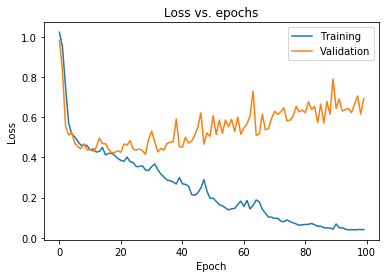

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
# Re-build the model with weight decay and dropout layers
def get_regularized_model(wd, rate):
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd), input_shape=(X_train.shape[1],)),
        Dropout(rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])

    return model


In [15]:
# Compile the model

model = get_regularized_model(1e-5, .3)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [16]:
# Train the model, with some of the data reserved for validation
history = model.fit(X_train, y_train, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [17]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)


45/1 - 0s - loss: 0.5427 - mse: 0.6022


[0.6087879690859053, 0.6022311]

#### Plot the learning curves

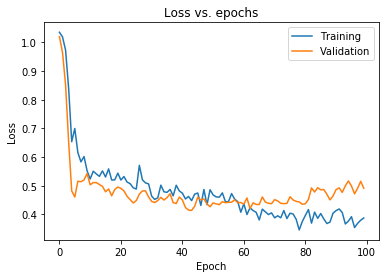

In [18]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [19]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class PredictingCallback(Callback):
    def on_predict_begin(self, logs=None):
        print("Predicting has begun")
    
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Batch {batch} has bugun")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Batch {batch} has ended")
        
    def on_predict_end(self, logs=None):
        print("Predicting has ended")
        
        
        
        
        


In [20]:
# Re-build the model
model = get_regularized_model(1e-5, .3)


In [21]:
# Compile the model
model.compile(optimizer='adam', loss='mse')


#### Train the model with the callback

# Train the model, with some of the data reserved for validation



In [22]:
# Evaluate the model

history = model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=.15, callbacks=[PredictingCallback()], verbose=False)

In [23]:
model.evaluate(X_test, y_test, callbacks=[PredictingCallback()], verbose=False)

0.7521706872516208

In [24]:
# Make predictions with the model
model.predict(X_test, callbacks=[PredictingCallback()])


Predicting has begun
Batch 0 has bugun
Batch 0 has ended
Batch 1 has bugun
Batch 1 has ended
Predicting has ended


array([[0.02002033],
       [0.04087448],
       [0.03145467],
       [0.03282003],
       [0.02322818],
       [0.06007919],
       [0.084079  ],
       [0.03176121],
       [0.09151289],
       [0.05059693],
       [0.10478155],
       [0.09961314],
       [0.04540822],
       [0.02520752],
       [0.07474785],
       [0.06591031],
       [0.04331044],
       [0.03104244],
       [0.02631791],
       [0.02555668],
       [0.04487289],
       [0.09315269],
       [0.08200098],
       [0.06565671],
       [0.10793106],
       [0.04684505],
       [0.11501434],
       [0.06506341],
       [0.17117603],
       [0.1729508 ],
       [0.13245666],
       [0.13946933],
       [0.13792215],
       [0.02406134],
       [0.04697897],
       [0.02206445],
       [0.08149689],
       [0.03547828],
       [0.08082533],
       [0.02701386],
       [0.14340082],
       [0.03641159],
       [0.0913952 ],
       [0.03717376],
       [0.06888003]], dtype=float32)

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [55]:
# Re-train the unregularised model
model = get_model()
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
unreg_history = model.fit(X_train, y_train, epochs=100, validation_split=0.15, batch_size=64, verbose=False,
         callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01)])


In [56]:
# Evaluate the model on the test set

model.evaluate(X_test, y_test, verbose=2)

45/1 - 0s - loss: 0.5705 - mae: 0.5872


[0.5871828344133165, 0.5871828]

In [57]:
# Re-train the regularised model
regmodel=get_regularized_model(1e-3, .3)
regmodel.compile(optimizer='adam', loss='mae', metrics=['mae'])
reg_history = regmodel.fit(X_train, y_train, epochs=100, validation_split=0.15, batch_size=64, verbose=False,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01)])


In [58]:
# Evaluate the model on the test set
regmodel.evaluate(X_test, y_test, verbose=2)


45/1 - 0s - loss: 0.6465 - mae: 0.5569


[0.6739266633987426, 0.5569182]

#### Plot the learning curves

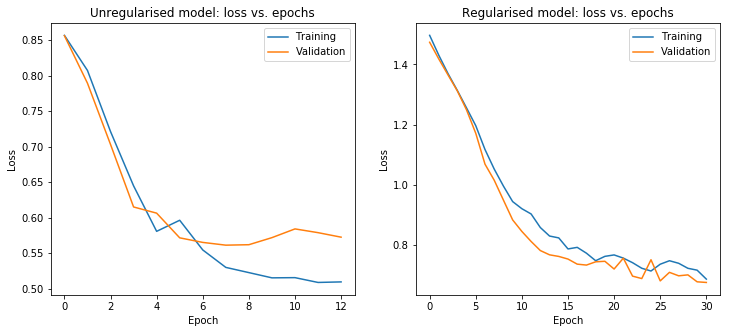

In [59]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()